In [22]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# getting latitude and longitude values
!pip install opencage
from opencage.geocoder import OpenCageGeocode
from pprint import pprint

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for webscraping import Beautiful Soup 
!pip install bs4
from bs4 import BeautifulSoup
import xml
from html.parser import HTMLParser
import requests
import re

# for text ripping
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS

# Downloading folium, if not installed
!conda install -c conda-forge folium=0.5.0 --yes
import folium # Map plotting library
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [44]:
# send the GET request
data = requests.get("https://www.nufusune.com/uskudar-mahalleleri-koyleri-istanbul").text

In [45]:
soup = BeautifulSoup(data, 'html.parser')
city = []

In [46]:
# append the data into the list
for row in soup.find_all("ol", class_="custom-counter")[0].findAll("li"):
    city.append(row.text)

In [47]:
city = pd.DataFrame({"Neighborhoods": city})
city.head(10)

,Neighborhoods
0,ACIBADEM MAHALLESİ
1,AHMEDİYE MAHALLESİ
2,ALTUNİZADE MAHALLESİ
3,AZİZ MAHMUT HÜDAYİ MAHALLESİ
4,BAHÇELİEVLER MAHALLESİ
5,BARBAROS MAHALLESİ
6,BEYLERBEYİ MAHALLESİ
7,BULGURLU MAHALLESİ
8,BURHANİYE MAHALLESİ
9,CUMHURİYET MAHALLESİ


In [49]:
#removing text
for i in stop :
    city = city.replace(to_replace='MAHALLESİ', value="",regex=True)
city.head()

,Neighborhoods
0,ACIBADEM
1,AHMEDİYE
2,ALTUNİZADE
3,AZİZ MAHMUT HÜDAYİ
4,BAHÇELİEVLER


In [50]:
# print the number of rows of the dataframe
city.shape

(33, 1)

In [51]:
key = 'ac2a83debe8745ac945cf623945274fb'
geocoder = OpenCageGeocode(key)

In [52]:
enco = ' ÜSKÜDAR İSTANBUL'

lat = []
lon = []

for name in city['Neighborhoods']:
    query = str(name) + enco
    result = geocoder.geocode(query)
    lat.append(result[0]['geometry']['lat'])
    lon.append(result[0]['geometry']['lng'])

city['Latitudes'] = lat
city['Longitudes'] = lon

In [53]:
city.head()

,Neighborhoods,Latitudes,Longitudes
0,ACIBADEM,41.006233,29.052894
1,AHMEDİYE,41.018490,29.016439
2,ALTUNİZADE,41.018351,29.044244
3,AZİZ MAHMUT HÜDAYİ,41.022494,29.011705
4,BAHÇELİEVLER,41.053384,29.079710


In [55]:
#changing columns names
city.rename(columns= { 'Latitudes' : 'Latitude' , 'Longitudes' : 'Longitude'} , inplace=True)
city.head()

,Neighborhoods,Latitude,Longitude
0,ACIBADEM,41.006233,29.052894
1,AHMEDİYE,41.018490,29.016439
2,ALTUNİZADE,41.018351,29.044244
3,AZİZ MAHMUT HÜDAYİ,41.022494,29.011705
4,BAHÇELİEVLER,41.053384,29.079710


In [63]:
gman_lat = 41.032996
gman_lng = 29.072434

# Creates map of Greater Manchester using latitude and longitude values
map_city = folium.Map(location=[gman_lat, gman_lng], zoom_start=12)

# Add markers to map
for lat, lng, neighborhood in zip(city['Latitude'], city['Longitude'], city['Neighborhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  
    
map_city

In [64]:
# API Retreving stuff:

CLIENT_ID = 'XEIY3JJQY0QPPPG2MDYWUF11EPSEOHRZJBCJCCIFVJYBZ10O'
CLIENT_SECRET = 'LIANY3ONJGEYMTTUHOQSOS2S33Q4K4VABZPEYAMU2YDLR301'
VERSION = '20200415'

In [65]:
# Defining own function to get the name of the category

def get_category_type(row):
    
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [66]:
# Finding out the number of collisions if any

df=city

col = 0
explored_lat_lng = []
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighborhoods']):
    if (lat, lng) in explored_lat_lng:
        col = col + 1
    else:
        explored_lat_lng.append((lat, lng))

print("Collisions : ", col)

Collisions :  0


In [67]:
# Using the FourSquare API on all neighbourhoods

explore_df_list = []

for i, nbd_name in enumerate(df['Neighborhoods']):  
    try :
        ### Getting the data of neighbourhood
        nbd_name = df.loc[i, 'Neighborhoods']
        nbd_lat = df.loc[i, 'Latitude']
        nbd_lng = df.loc[i, 'Longitude']

        radius = 1000 # Setting the radius as 1000 metres
        LIMIT = 100 # Getting the top 100 venues

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nbd_lat, nbd_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']

        nearby = json_normalize(results) # Flattens JSON
        
         # Filtering the columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        # Renaming the columns
        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        # Gets the categories
        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        # Gets the data required
        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  # Converts the numpy array to a python list
            f_list = [nbd_name, nbd_lat, nbd_lng] + s_list
            explore_df_list.append(f_list)

    except Exception as e:
        pass

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [68]:
# Creating a dataframe for performing clustering operations

explore_df = pd.DataFrame([item for item in explore_df_list])
explore_df.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_df.head(10)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue Name,Venue Category,Venue Latitude,Venue Longitude
0,ACIBADEM,41.006233,29.052894,Has Manti,Manti Place,41.006345,29.051485
1,ACIBADEM,41.006233,29.052894,Türk Telekom Halı Saha,Soccer Field,41.006896,29.050376
2,ACIBADEM,41.006233,29.052894,Kukis,Pastry Shop,41.007837,29.049711
3,ACIBADEM,41.006233,29.052894,Macrocenter Acıbadem,Grocery Store,41.008670,29.050506
4,ACIBADEM,41.006233,29.052894,Valievleri Park Acibadem,Park,41.006124,29.054167
5,ACIBADEM,41.006233,29.052894,Zuhal Müzik,Music Store,41.002600,29.054736
6,ACIBADEM,41.006233,29.052894,Toccare Cafe & Restaurant,Italian Restaurant,41.008998,29.050514
7,ACIBADEM,41.006233,29.052894,Kukis Bahçe,Café,41.007866,29.049770
8,ACIBADEM,41.006233,29.052894,Shaba Health & Fitness Club,Gym / Fitness Center,41.003438,29.053700
9,ACIBADEM,41.006233,29.052894,Starbucks,Coffee Shop,41.002587,29.054821


In [69]:
explore_df.shape

(3020, 7)

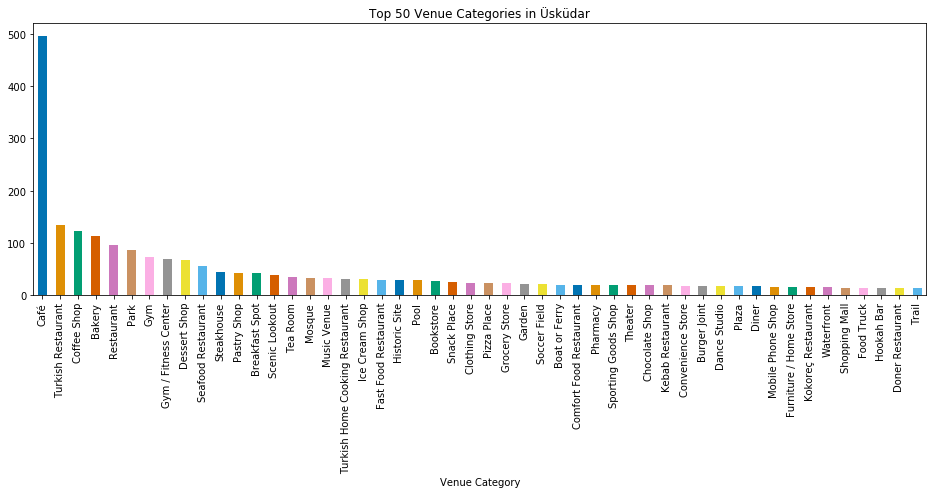

In [73]:
import seaborn as sns
colorss = sns.color_palette('colorblind')

temp = explore_df.groupby("Venue Category").count()

#create a dataframe with top 50 venue categories by count
temp = temp.sort_values(by = ["Neighbourhood"], 
                        axis = 0, 
                        ascending = False).head(50)

#plot the top 50 venue categories
temp["Venue Name"].plot(kind = "bar", 
                   figsize = (16, 5), 
                   color = colorss ,
                   title = "Top 50 Venue Categories in Üsküdar")


In [79]:
#Performing one-hot encoding to analyze Neighbourhoods

# One hot encoding
man_onehot = pd.get_dummies(explore_df[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
man_onehot['Neighbourhood'] = explore_df['Neighbourhood'] 

# Move neighborhood column to the first column
fixed_columns = [man_onehot.columns[-1]] + man_onehot.columns[:-1].values.tolist()
man_onehot = man_onehot[fixed_columns]

man_onehot.head(5)

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Garden,Big Box Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Brasserie,Breakfast Spot,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Campground,Candy Store,Carpet Store,Cheese Shop,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indie Movie Theater,Internet Cafe,Italian Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Kuruyemişçi,Lake,Lighthouse,Lingerie Store,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Meyhane,Middle Eastern Restaurant,Middle School,Miscellaneous Shop,Mobile Phone Shop,Mosque,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,National Park,Nature Preserve,Night Market,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pide Place,Pier,Pilates Studio,Pilavcı,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Pub,Public Art,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Sake Bar,Salon / Barbershop,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Trail,Transportation Service,Tunnel,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Video Game Store,Volleyball Court,Water Park,Waterfront,Women's Store
0,ACIBADEM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ACIBADEM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [80]:
#Aggregating venues by Neighbourhoods

man_grouped = man_onehot.groupby('Neighbourhood').mean().reset_index()
man_grouped.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Garden,Big Box Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Brasserie,Breakfast Spot,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Campground,Candy Store,Carpet Store,Cheese Shop,Chocolate Shop,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cruise,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fish Taverna,Fishing Spot,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Ice Cream Shop,Indie Movie Theater,Internet Cafe,Italian Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Kuruyemişçi,Lake,Lighthouse,Lingerie Store,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Meyhane,Middle Eastern Restaurant,Middle School,Miscellaneous Shop,Mobile Phone Shop,Mosque,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,National Park,Nature Preserve,Night Market,Nightclub,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pide Place,Pier,Pilates Studio,Pilavcı,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Pub,Public Art,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Sake Bar,Salon / Barbershop,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Tourist Information Center,Toy / Game Store,Trail,Transportation Service,Tunnel,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Video Game Store,Volleyball Court,Water Park,Waterfront,Women's Store
0,ACIBADEM,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.030000,0.000000,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,0.0,0.030000,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.010000,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.00,0.0,0.0,0.03,0.0,0.090000,0.0,0.100000,0.0,0.0,0.00,0.0,0.0,0.000000,0.030000,0.0,0.0,0.00,0.00,0.0,0.02,0.000000,0.040000,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.03,0.0,0.0,0.0,0.01,0.020000,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.0,0.0,0.0,0.01,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.01,0.01,0.0,0.0,0.010000,0.040000,0.030000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,0.00,0.010000,0.0,0.0,0.02,0.02,0.00,0.010000,0.0,0.00,0.000000,0.0,0.0,0.0,0.01,0.00,0.01,0.0,0.000000,0.01,

In [82]:
# Creating a function to return the most common venues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
#Creating a new dataframe to get the top 5 venues

num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = man_grouped['Neighbourhood']

for ind in np.arange(man_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(man_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ACIBADEM,Coffee Shop,Clothing Store,Café,Restaurant,Gym
1,AHMEDİYE,Café,Turkish Restaurant,Coffee Shop,Mosque,Turkish Home Cooking Restaurant
2,ALTUNİZADE,Café,Gym / Fitness Center,Gym,Coffee Shop,Music Venue
3,AZİZ MAHMUT HÜDAYİ,Café,Coffee Shop,Turkish Restaurant,Historic Site,Restaurant
4,BAHÇELİEVLER,Café,Park,Coffee Shop,Dessert Shop,Breakfast Spot
5,BARBAROS,Café,Turkish Restaurant,Coffee Shop,Gym / Fitness Center,Bakery
6,BEYLERBEYİ,Seafood Restaurant,Café,Restaurant,Turkish Restaurant,Bakery
7,BULGURLU,Café,Bakery,Dessert Shop,Gym / Fitness Center,Coffee Shop
8,BURHANİYE,Café,Park,Soccer Field,Fast Food Restaurant,Restaurant
9,CUMHURİYET,Café,Park,Bakery,Dessert Shop,Restaurant


In [84]:
man_grouped_clustering = man_grouped.drop('Neighbourhood', 1)

In [85]:
#Using K-Means clustering
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()


In [86]:
max_range = 20 # Maximum range of clusters

In [87]:

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kgc = man_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

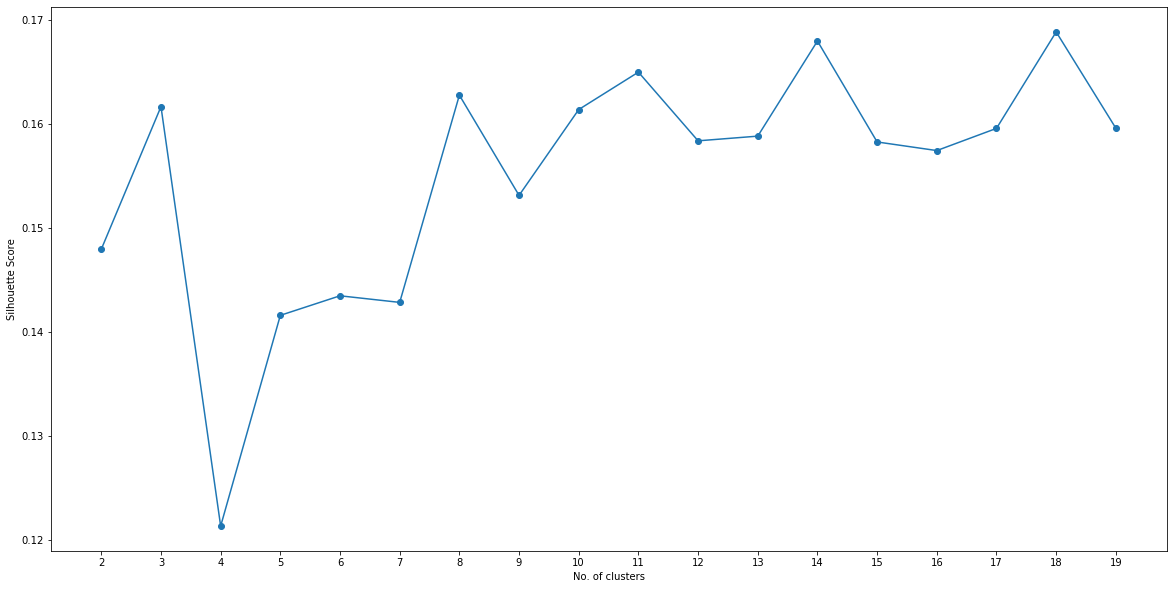

In [88]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [90]:
#From the graph the optimal number is found out to be considered for our clustering

opt = np.argmax(scores) + 2 # Finds the optimal value
opt

18

In [91]:
#K-Means clustering for the optimal number of clusters
kclusters = opt

# Run k-means clustering
kgc = man_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(kgc)

In [92]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [94]:
man_merged = df
man_merged = man_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighborhoods')
man_merged.dropna(inplace = True)
man_merged['Cluster Labels'] = man_merged['Cluster Labels'].astype(int)
man_merged.head(10)


,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ACIBADEM,41.006233,29.052894,6,Coffee Shop,Clothing Store,Café,Restaurant,Gym
1,AHMEDİYE,41.018490,29.016439,8,Café,Turkish Restaurant,Coffee Shop,Mosque,Turkish Home Cooking Restaurant
2,ALTUNİZADE,41.018351,29.044244,15,Café,Gym / Fitness Center,Gym,Coffee Shop,Music Venue
3,AZİZ MAHMUT HÜDAYİ,41.022494,29.011705,8,Café,Coffee Shop,Turkish Restaurant,Historic Site,Restaurant
4,BAHÇELİEVLER,41.053384,29.079710,3,Café,Park,Coffee Shop,Dessert Shop,Breakfast Spot
5,BARBAROS,41.012698,29.031529,2,Café,Turkish Restaurant,Coffee Shop,Gym / Fitness Center,Bakery
6,BEYLERBEYİ,41.041793,29.046546,9,Seafood Restaurant,Café,Restaurant,Turkish Restaurant,Bakery
7,BULGURLU,41.018331,29.079324,14,Café,Bakery,Dessert Shop,Gym / Fitness Center,Coffee Shop
8,BURHANİYE,41.028720,29.052767,10,Café,Park,Soccer Field,Fast Food Restaurant,Restaurant
9,CUMHURİYET,41.010880,29.080759,14,Café,Park,Bakery,Dessert Shop,Restaurant


In [96]:
# Create map
map_clusters = folium.Map(location=[gman_lat, gman_lng], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(man_merged['Latitude'], man_merged['Longitude'], man_merged['Neighborhoods'], man_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.features.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

In [97]:
val = 1
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
25,SALACAK,Café,Historic Site,Restaurant,Tea Room,Gym


In [98]:
val = 2
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
22,MEHMET AKİF ERSOY,Café,Coffee Shop,Bakery,Turkish Restaurant,Gym / Fitness Center
31,YAVUZTÜRK,Café,Pizza Place,Bakery,Coffee Shop,Supermarket


In [99]:
val = 3
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,BARBAROS,Café,Turkish Restaurant,Coffee Shop,Gym / Fitness Center,Bakery
24,MURATREİS,Café,Bakery,Turkish Restaurant,Pastry Shop,Dance Studio
26,SELAMİ ALİ,Café,Bakery,Pastry Shop,Turkish Restaurant,Park
30,VALİDE-İ ATİK,Café,Turkish Restaurant,Bakery,Gym,Pool
32,ZEYNEP KAMİL,Café,Turkish Restaurant,Bakery,Gym,Gym / Fitness Center


In [100]:
val = 4
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,BAHÇELİEVLER,Café,Park,Coffee Shop,Dessert Shop,Breakfast Spot
12,GÜZELTEPE,Café,Gym / Fitness Center,Bakery,Breakfast Spot,Steakhouse


In [101]:
val = 5
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
14,KANDİLLİ,Boat or Ferry,Café,Turkish Restaurant,Restaurant,Steakhouse


In [102]:
val = 6
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,KİRAZLITEPE,Turkish Restaurant,Café,Scenic Lookout,Park,Ice Cream Shop
21,KÜPLÜCE,Café,Turkish Restaurant,Park,Snack Place,Scenic Lookout


In [103]:
val = 7
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ACIBADEM,Coffee Shop,Clothing Store,Café,Restaurant,Gym
29,ÜNALAN,Clothing Store,Café,Coffee Shop,Restaurant,Department Store


In [104]:
val = 8
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,ÇENGELKÖY,Café,Seafood Restaurant,Coffee Shop,Dessert Shop,Kokoreç Restaurant


In [105]:
val = 9
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,AHMEDİYE,Café,Turkish Restaurant,Coffee Shop,Mosque,Turkish Home Cooking Restaurant
3,AZİZ MAHMUT HÜDAYİ,Café,Coffee Shop,Turkish Restaurant,Historic Site,Restaurant
23,MİMAR SİNAN,Café,Coffee Shop,Turkish Restaurant,Restaurant,Mosque
28,SULTANTEPE,Café,Coffee Shop,Turkish Restaurant,Restaurant,Historic Site


In [107]:
val = 10
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,BEYLERBEYİ,Seafood Restaurant,Café,Restaurant,Turkish Restaurant,Bakery


In [108]:
val = 11
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,BURHANİYE,Café,Park,Soccer Field,Fast Food Restaurant,Restaurant


In [109]:
val = 12
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
27,SELİMİYE,Café,Boat or Ferry,Pier,Restaurant,Steakhouse


In [110]:
val = 13
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,FERAH,Café,Turkish Restaurant,Bakery,Snack Place,Park
15,KISIKLI,Café,Turkish Restaurant,Bakery,Dessert Shop,Restaurant
19,KÜÇÜK ÇAMLICA,Café,Turkish Restaurant,Bakery,Park,Restaurant


In [111]:
val = 14
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,KULELİ,Café,Seafood Restaurant,Garden,Bakery,Pool


In [112]:
val = 15
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,BULGURLU,Café,Bakery,Dessert Shop,Gym / Fitness Center,Coffee Shop
9,CUMHURİYET,Café,Park,Bakery,Dessert Shop,Restaurant


In [113]:
val = 16
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,ALTUNİZADE,Café,Gym / Fitness Center,Gym,Coffee Shop,Music Venue


In [114]:
val = 17
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,İCADİYE,Café,Pastry Shop,Turkish Restaurant,Dance Studio,Dessert Shop
18,KUZGUNCUK,Café,Pastry Shop,Restaurant,Turkish Restaurant,Park


In [115]:
val = 18
man_merged.loc[man_merged['Cluster Labels'] == (val - 1), man_merged.columns[[0] + np.arange(4, man_merged.shape[1]).tolist()]]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
20,KÜÇÜKSU,Café,Bakery,Steakhouse,Gym,Restaurant
